# Theory, Applications, and Tools for Multiscale Kinetic Modeling
# pGrAdd Demonstration

# 1. Introduction

<img src="images/pGrAdd_RGB_github.png" width=400>

A Python package and database, developed by the Vlachos Research Group at the University of Delaware implements the **F**irst-**P**rinciples **S**emi-**E**mpirical (FPSE) **G**roup **A**dditivity
(GA) method for estimating thermodynamic properties of molecules. First introduced by Benson et al. for gas molecules and
was later extended by Kua et al. to species adsorbed on catalytic surfaces. GA relies on graph theory defining each molecule
as a collection of groups and their frequency of occurrence. The values of GA groups are determined from DFT-calculated
thermodynamic properties of a (training) set of molecules by linear regression to minimize the difference of thermodynamic
properties of molecules predicted by the GA from those estimated via DFT. This package implements four group additivity
schemes in six databases (See below) and will convert a molecule entered as a **S**implified **M**olecular-**I**nput
**L**ine-**E**ntry **S**ystem (SMILES) providing the constituent groups, their frequency of occurrence, and estimated
thermodynamic properties for that molecule. pgradd also provides a general GA framework for implementing a custom group additivity scheme from your *ab initio* data and regression to groups.

# 2. Available databases

-  Benson's gas molecule group additivity (BensonGA)
-  Salciccioli et al. (2012) adsorbate on Pt(111) group additivity scheme (SalciccioliGA2012)
-  Gu et al. (2017) solvated adsorbate on Pt(111) group additivity scheme (GuSolventGA2017Aq, GuSolventGA2017Vac)
-  Wittreich (2018) adsorbate on Pt(111). Subset of Gu et al. including only surface species, group values regressed with OLS/GLS (Maximum Likelihood) and DFT data processed with `pmutt`_ (GRWSurface2018) **Deprecated**
-  Wittreich (2018) solvated adsorbate on Pt(111). Subset of Gu et al. including only surface species, group values regressed with OLS/GLS (Maximum Likelihood) and DFT data processed with `pmutt`_ (GRWAqueous2018)
-  Xie (2022) Database for hydrocarbon species on Ru(0001) (XieGA2022)
- Wittreich/Xie (2023) adsorbate on Pt(111). Subset of Gu et al. including only surface species. Update to previous GRWSurface2018 (PtSurface2023)

# 3. Installation

## pip install pgradd

or upgrade from a previous version

## pip install --upgrade pgradd


# 4. Theory

<img src="images/GATheory.jpg" width=800>

# 5. References

- [A Python Multiscale Thermochemistry Toolbox (pMuTT) for thermochemical and kinetic parameter estimation; Lym, Wittreich, et al; Computer Physics Communications, 2020](https://scholar.google.com/scholar?oi=bibs&cluster=17816609206929175595&btnI=1&hl=en)
- [Python Group Additivity (pGrAdd) software for estimating species thermochemical properties; Wittreich, et al; Computer Physics Communications, 2022](https://scholar.google.com/scholar?oi=bibs&cluster=7963801704969122168&btnI=1&hl=en)
- [Microkinetic modeling of surface catalysis; Wittreich, et al; Handbook of Materials Modeling: Applications, 2020](https://scholar.google.com/scholar?oi=bibs&cluster=2412312200916247815&btnI=1&hl=en)

# 6. Demonstration

### Load the pGrAdd libraries

In [1]:
import pgradd

print(pgradd.__file__)
print("Installed version :", pgradd.__version__)

C:\Users\gerhard\anaconda3\lib\site-packages\pgradd\__init__.py
Installed version : 2.9.11


In [2]:
from pgradd.GroupAdd import GroupLibrary
import pgradd.ThermoChem

lib = GroupLibrary.Load('GRWSurface2018')

### Find the groups in a molecule

**Molecule:** CCH<sub>2</sub>C(S)

**SMILES:** C(CC([Pt])([Pt])[Pt])([Pt])([Pt])[Pt])

<img src="images/CCH2C(S).png" width=400>

In [3]:
groups = lib.GetDescriptors('C(CC([Pt])([Pt])[Pt])([Pt])([Pt])[Pt]')
print('Group              Frequency')
print('-----              ---------')
for x in groups:
    print('{0:20s}  {1:g}'.format(x, groups[x]))

Group              Frequency
-----              ---------
C(C)(Pt)3             2
C(C)2(H)2             1
CCPt3                 2
surface-ring strain   0.608


### Calculate thermodynamic properties of the molecule

In [4]:
thermochem = lib.Estimate(groups, 'thermochem')
S = thermochem.get_S(T=298.15, units='cal/mol/K')
H = thermochem.get_H(T=298.15, units='kcal/mol')
G = thermochem.get_G(T=298.15, units='kJ/mol')
HoRT = thermochem.get_HoRT(298.15)
print('Entropy(298 K)  = {0:5.2f} [cal/mol/K]'.format(S))
print('Enthalpy(298 K) = {0:5.2f} [kcal/mol]'.format(H))
print('Gibb''s(298 K)    = {0:5.2f} [kJ/mol]'.format(G))
print('Dimensionless Enthalpy(298 K)  = {0:5.2f}'.format(HoRT))

Entropy(298 K)  = 10.47 [cal/mol/K]
Enthalpy(298 K) = 16.66 [kcal/mol]
Gibbs(298 K)    = 56.64 [kJ/mol]
Dimensionless Enthalpy(298 K)  = 28.12


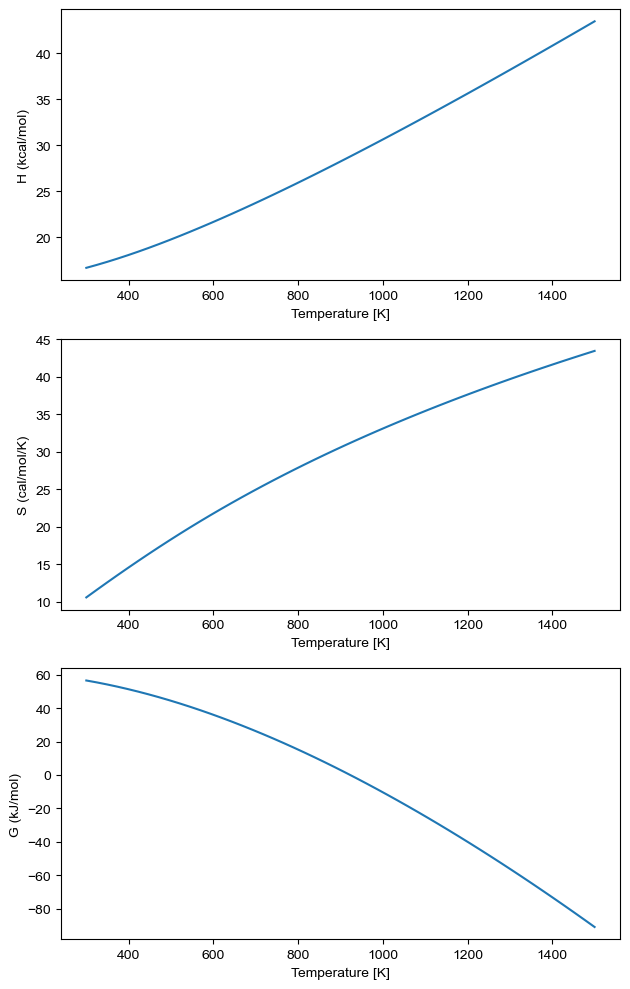

In [5]:
import numpy as np
from pmutt import plot_1D
from matplotlib import pyplot as plt

T = np.linspace(300, 1500)
fig1, ax1 = plot_1D(thermochem, x_name='T', x_values=T,
                    methods=('get_H', 'get_S', 'get_G'),
                    get_H_kwargs={'units':'kcal/mol'},
                    get_S_kwargs={'units':'cal/mol/K'},
                    get_G_kwargs={'units': 'kJ/mol'})
fig1.set_figheight(10)
ax1[0].set_ylabel('H (kcal/mol)')
ax1[1].set_ylabel('S (cal/mol/K)')
ax1[2].set_ylabel('G (kJ/mol)')
ax1[0].set_xlabel('Temperature [K]')
ax1[1].set_xlabel('Temperature [K]')
ax1[2].set_xlabel('Temperature [K]')
plt.tight_layout()
plt.show()

In [6]:
from pmutt.empirical.nasa import Nasa
from pmutt.io.thermdat import write_thermdat
N = []
N.append(Nasa.from_model(thermochem, name='CCH2C(S)', T_low=300, T_high=1500, phase='S', elements={'C': 3, 'H': 2}))
print(write_thermdat(N))

THERMO ALL
       100       500      1500
CCH2C(S)        20230814C   3H   2          S300.0     1500.0    569.4         1
-1.09323447E-01 2.89705084E-02-2.69693134E-05 1.27357992E-08-2.40993319E-12    2
 7.32106023E+03-1.71685329E+00-2.17229432E+00 4.29492671E-02-7.17187567E-05    3
 8.78644087E-08-5.23536147E-11 7.60690677E+03 7.35592183E+00                   4
END


### Find the groups in a molecule

**Molecule:** CH<sub>3</sub>CHOH(S)

**SMILES:** C([Pt])(O)C

<img src="images/CH3CHOH(S).png" width=400>

In [7]:
groups = lib.GetDescriptors('C([Pt])(O)C')
print('Group              Frequency')
print('-----              ---------')
for x in groups:
    print('{0:20s}  {1:g}'.format(x, groups[x]))

Group              Frequency
-----              ---------
C(C)(H)(O)(Pt)        1
O(C)(H)               1
C(C)(H)3              1
CCPt1                 1


### Calculate thermodynamic properties of the molecule

In [8]:
thermochem = lib.Estimate(groups, 'thermochem')
S = thermochem.get_S(T=298.15, units='cal/mol/K')
H = thermochem.get_H(T=298.15, units='kcal/mol')
G = thermochem.get_G(T=298.15, units='kJ/mol')
HoRT = thermochem.get_HoRT(298.15)
print('Entropy(298 K)  = {0:5.2f} [cal/mol/K]'.format(S))
print('Enthalpy(298 K) = {0:5.2f} [kcal/mol]'.format(H))
print('Gibb''s(298 K)    = {0:5.2f} [kJ/mol]'.format(G))
print('Dimensionless Enthalpy(298 K)  = {0:5.2f}'.format(HoRT))

Entropy(298 K)  = 19.83 [cal/mol/K]
Enthalpy(298 K) = -73.15 [kcal/mol]
Gibbs(298 K)    = -330.78 [kJ/mol]
Dimensionless Enthalpy(298 K)  = -123.46


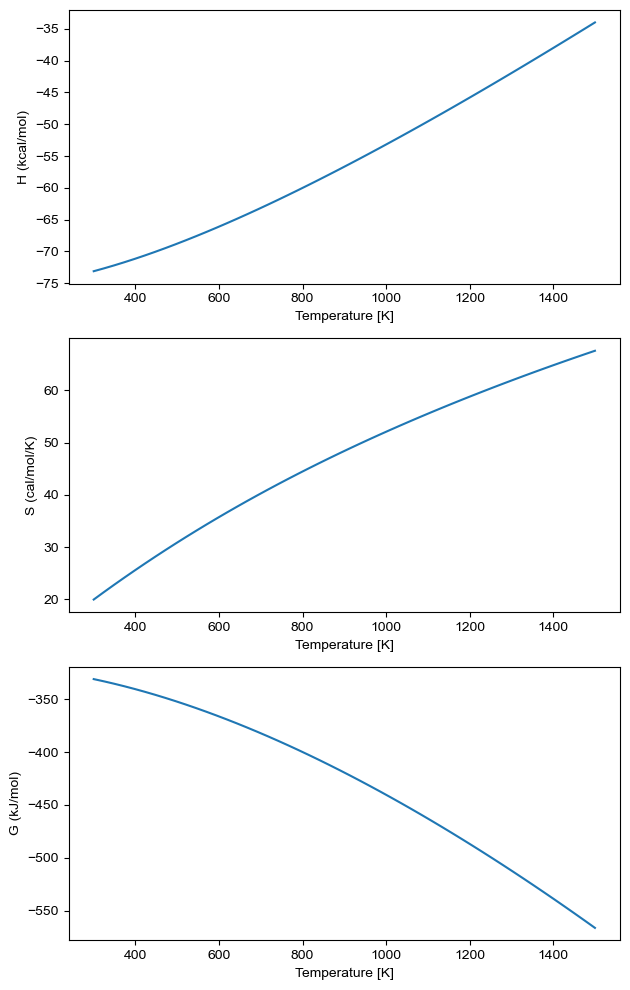

In [9]:
import numpy as np
from pmutt import plot_1D
from matplotlib import pyplot as plt

T = np.linspace(300, 1500)
fig1, ax1 = plot_1D(thermochem, x_name='T', x_values=T,
                    methods=('get_H', 'get_S', 'get_G'),
                    get_H_kwargs={'units':'kcal/mol'},
                    get_S_kwargs={'units':'cal/mol/K'},
                    get_G_kwargs={'units': 'kJ/mol'})
fig1.set_figheight(10)
ax1[0].set_ylabel('H (kcal/mol)')
ax1[1].set_ylabel('S (cal/mol/K)')
ax1[2].set_ylabel('G (kJ/mol)')
ax1[0].set_xlabel('Temperature [K]')
ax1[1].set_xlabel('Temperature [K]')
ax1[2].set_xlabel('Temperature [K]')
plt.tight_layout()
plt.show()

In [10]:
from pmutt.empirical.nasa import Nasa
from pmutt.io.thermdat import write_thermdat
N = []
N.append(Nasa.from_model(thermochem, name='CH3CHOH(S)', T_low=300, T_high=1500, phase='S', elements={'C': 2, 'H': 5, 'O':1}))
print(write_thermdat(N))

THERMO ALL
       100       500      1500
CH3CHOH(S)      20230814C   2H   5O   1     S300.0     1500.0    520.4         1
-5.50485153E-01 4.08240031E-02-3.66237822E-05 1.78826678E-08-3.59842663E-12    2
-3.81664265E+04 2.42845335E+00 7.97334744E+00-3.84997759E-02 2.37886894E-04    3
-4.00612012E-07 2.33603922E-10-3.88944029E+04-3.14648816E+01                   4
END
